<a href="https://colab.research.google.com/github/itspritish/nlp/blob/master/Embedding_pretrain_glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import re
from keras.preprocessing.sequence import pad_sequences

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
cp drive/My\ Drive/dataml/glove.6B.50d.txt .

In [0]:
docs = ['Well done!', 'Good work', 'Great effort', 'nice work', 'Excellent!',
        'Weak', 'Poor effort!', 'not good', 'poor work', 'Could have done better.']

labels = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

In [0]:
word2index, embedding_matrix = load_glove_embeddings('glove.6B.50d.txt', embedding_dim=50)

In [28]:
word2index['well']


143

In [0]:

def custom_tokenize(docs):
    output_matrix = []
    for d in docs:
        indices = []
        for w in d.split():
            indices.append(word2index[re.sub(r'[^\w\s]','',w).lower()])
        output_matrix.append(indices)
    return output_matrix
    
# Encode docs with our special "custom_tokenize" function
encoded_docs_ge = custom_tokenize(docs)
#print(encoded_docs_ge)

In [30]:
np.shape(padded_docs_ge)

(10, 5)

In [0]:
maxlen = 5
padded_docs_ge = pad_sequences(encoded_docs_ge, maxlen=maxlen, padding='post')

In [0]:
from keras.models import Model
from keras.layers import Embedding, Flatten, Dense, Input, Dropout, LSTM

embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                            output_dim=embedding_matrix.shape[1], 
                            input_length=maxlen,
                            weights=[embedding_matrix], 
                            trainable=False, 
                            name='embedding_layer')

i = Input(shape=(maxlen,), dtype='int32', name='main_input')
x = embedding_layer(i)
x = LSTM(50,return_sequences=True)(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
o = Dense(1, activation='sigmoid')(x)

model = Model(inputs=i, outputs=o)

In [61]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])  # Compile the model
print(model.summary())  # Summarize the model
model.fit(padded_docs_ge, labels, epochs=50, verbose=0)  # Fit the model
loss, accuracy = model.evaluate(padded_docs_ge, labels, verbose=0)  # Evaluate the model
print('Accuracy: %0.3f' % accuracy)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 5)                 0         
_________________________________________________________________
embedding_layer (Embedding)  (None, 5, 50)             20000050  
_________________________________________________________________
lstm_8 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
flatten_15 (Flatten)         (None, 250)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                16064     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65 

In [0]:
from keras.models import Model
from keras.layers import Embedding, Flatten, Dense, Input

embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                            output_dim=embedding_matrix.shape[1], 
                            input_length=maxlen,
                            weights=[embedding_matrix], 
                            trainable=False, 
                            name='embedding_layer')

i = Input(shape=(maxlen,), dtype='int32', name='main_input')
x = embedding_layer(i)
x = Flatten()(x)
o = Dense(1, activation='sigmoid')(x)

model = Model(inputs=i, outputs=o)


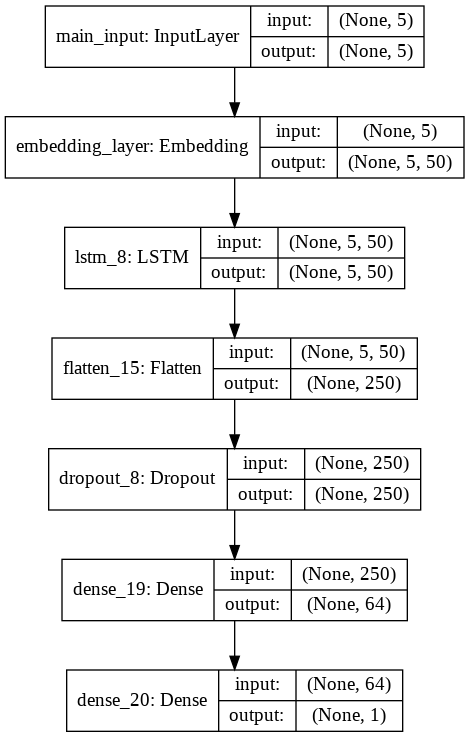

In [62]:
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

graph = plot_model(model, to_file='my_model.png', show_shapes=True)

graph


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 5)                 0         
_________________________________________________________________
embedding_layer (Embedding)  (None, 5, 50)             20000050  
_________________________________________________________________
lstm_5 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
flatten_9 (Flatten)          (None, 250)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                16064     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65  

In [89]:
from sklearn.metrics import confusion_matrix

"""docs = ['Well done!', 'Good work', 'Great effort', 'nice work', 'Excellent!',
        'Weak', 'Poor effort!', 'not good', 'poor work', 'Could have done better.']
"""
docs_test = ['Does not look good', 'that sucks', 'Great effort', 'try more' ]

encoded_docs_ge_test = custom_tokenize(docs_test)

maxlen = 5
padded_docs_ge_test = pad_sequences(encoded_docs_ge_test, maxlen=maxlen, padding='post')

labels_test = [0, 0, 1, 0]


y_pred = model.predict(padded_docs_ge_test)
print(y_pred)
y_pred =(y_pred>0.5)
list(y_pred)

cm = confusion_matrix(labels_test, y_pred)
print(cm)


[[0.00198116]
 [0.12003343]
 [0.99849844]
 [0.01032194]]
[[3 0]
 [0 1]]


In [0]:
import numpy as np
"""
https://gist.github.com/jovianlin/load_glove_embeddings.py
"""

def load_glove_embeddings(fp, embedding_dim, include_empty_char=True):
    """
    Loads pre-trained word embeddings (GloVe embeddings)
        Inputs: - fp: filepath of pre-trained glove embeddings
                - embedding_dim: dimension of each vector embedding
                - generate_matrix: whether to generate an embedding matrix
        Outputs:
                - word2coefs: Dictionary. Word to its corresponding coefficients
                - word2index: Dictionary. Word to word-index
                - embedding_matrix: Embedding matrix for Keras Embedding layer
    """
    # First, build the "word2coefs" and "word2index"
    word2coefs = {} # word to its corresponding coefficients
    word2index = {} # word to word-index
    with open(fp) as f:
        for idx, line in enumerate(f):
            try:
                data = [x.strip().lower() for x in line.split()]
                word = data[0]
                coefs = np.asarray(data[1:embedding_dim+1], dtype='float32')
                word2coefs[word] = coefs
                if word not in word2index:
                    word2index[word] = len(word2index)
            except Exception as e:
                print('Exception occurred in `load_glove_embeddings`:', e)
                continue
        # End of for loop.
    # End of with open
    if include_empty_char:
        word2index[''] = len(word2index)
    # Second, build the "embedding_matrix"
    # Words not found in embedding index will be all-zeros. Hence, the "+1".
    vocab_size = len(word2coefs)+1 if include_empty_char else len(word2coefs)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in word2index.items():
        embedding_vec = word2coefs.get(word)
        if embedding_vec is not None and embedding_vec.shape[0]==embedding_dim:
            embedding_matrix[idx] = np.asarray(embedding_vec)
    # return word2coefs, word2index, embedding_matrix
    return word2index, np.asarray(embedding_matrix)